This module is a reproduce of Grimadi et al. 2020 RSE - "Flood mapping under vegetation using single SAR acquisitions" [link](https://www.sciencedirect.com/science/article/pii/S0034425719306029?via%3Dihub#bb0510)

We use GEE to process the datasets

In [100]:
import rasterio

In [99]:
import geemap
import numpy as np
import ee
from pysheds.grid import Grid
# from osgeo import gdal

ModuleNotFoundError: No module named 'osgeo'

In [2]:
Map= geemap.Map(center=[40,-100], zoom=4)
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

# Data preparation

The data we need to reproduce this result:

- SAR backscatter data HH polarized (Sentinel-1 IW mode)
- DEM (SRTM)
- Land Cover (Copernicus Global Land Cover Layers: CGLS-LC100 collection 2)
- Open water observation (JRC Monthly Water History, v1.1)

In [3]:
#study area
region_shp= '/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/Houston_basin.shp'
region= geemap.shp_to_ee(region_shp)
Map.addLayer(region)

In [4]:
SAR= ee.Image('COPERNICUS/S1_GRD/S1B_IW_GRDH_1SDV_20170830T122203_20170830T122232_007169_00CA2C_E7BF').clip(region)
Map.addLayer(SAR.select('VH'), {'min':-30, 'max':5}, 'SAR')

In [18]:
land= ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V/Global").select('discrete_classification').mosaic().clip(region)
# land= land.map(lambda image: image.clip(region))

Map.addLayer(land,  {'min': 0.0,
  'max': 200.0,
  'palette': [
    "032f7e","02740b","02740b","8cf502","8cf502","a4da01",
    "ffbd05","ffbd05","7a5a02","f0ff0f","869b36","6091b4",
    "999999","ff4e4e","ff4e4e","ffffff","feffc0","020202",
    "020202"]},
  name='landcover' )

In [9]:
water= ee.Image('JRC/GSW1_0/GlobalSurfaceWater').clip(region)
Map.addLayer(water, {
  'bands': ['occurrence'],
  'min': 0.0,
  'max': 100.0,
  'palette': ['ffffff', 'fffcb8', '0905ff']
}, 'water')

In [20]:
# geemap.ee_export_image(land, filename='data/landcover.tif', region=region.geometry(), scale=90, file_per_band=True)

Generating URL ...
Please wait ...
Data downloaded to /Users/allen/Documents/Python/FloodDetection/data


In [155]:
"Credit: Ben Lewis"
import numpy as np
import scipy.optimize, scipy.stats

def fuzzy_smf(x, a, b):
    """
    Fuzzy step function
    
    Examples:
    >>> x = np.arange(7)
    >>> fuzzy_smf(x, 3, 5).tolist()
    [0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0]
    >>> fuzzy_zmf(x, 3, 5).tolist()
    [1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0]
    """
    delta = b - a
    middle = np.mean([a, b])
    
    A = 2 * ((x - a) / delta)**2
    B = 2 * ((x - b) / delta)**2
    
    result = np.where(x < middle, A, 1 - B)
    result[x < a] = 0
    result[x > b] = 1
    return result

def fuzzy_zmf(x, a, b):
    return 1 - fuzzy_smf(x, a, b)

def hist_fixedwidth(population, binwidth=0.1):
    """
    Return (frequency, centres) for a histogram with uniform-width bins
    
    >>> freq, centres = hist_fixedwidth(np.asarray([5, 9.5, 10.5, 6, 6, 6, 6, 6]), binwidth=2)
    >>> centres.tolist()
    [6.0, 8.0, 10.0]
    >>> freq.tolist() # 6/8 per 2; 0 per 2; 2/8 per 2
    [0.375, 0.0, 0.125]
    """
    # Could replace .max() with 0dB to discard non-negative samples?
    edges = np.arange(start=population.min(), stop=population.max() + binwidth, step=binwidth)
    counts, edges = np.histogram(population, bins=edges, density=True)
    centres = (edges[:-1] + edges[1:]) / 2
    return counts, centres

def find_mode(population):
    """
    Returns estimate of distribution mode.
    
    >>> round(find_mode(np.asarray([-10.05, 20.31, 20.29, 17, 20.27, 17, 37])), 1)
    20.3
    """
    counts, values = hist_fixedwidth(population)
    return values[counts.argmax()]

def leftFitNormal(population):
    """
    Obtain mode and standard deviation from the left side of a population.
    >>> mode, sigma = leftFitNormal(np.random.normal(loc=-20, scale=3, size=10000))
    >>> -22 < mode < -18
    True
    >>> round(sigma)
    3.0
    """
    # Quick alternative robust (but symmetric) fit:
    #median = np.nanmedian(population) 
    #MADstd = np.nanmedian(np.abs(population - median)) * 1.4826 # robust estimator
    
    std = np.nanstd(population) # naive initial estimate

    Y, X = hist_fixedwidth(population)
    
    # Take left side of distribution
    pos = Y.argmax()
    mode = X[pos]
    X = X[:pos+1]
    Y = Y[:pos+1]
    
    # fit gaussian to (left side of) distribution
    def gaussian(x, mean, sigma):
        return np.exp(-0.5 * ((x - mean)/sigma)**2) / (sigma * (2*np.pi)**0.5)
    (mean, std), cov = scipy.optimize.curve_fit(gaussian, X, Y, p0=[mode, std])
    
    return mode, std

def leftFitNormal2(population):
    """
    Obtain mode, right 1/20 maximum, and covariance of left fit.
    >>> mode, m20, measure = leftFitNormal2(np.random.normal(loc=-20, scale=3, size=5000))
    >>> m20 > -17
    True
    >>> 1 >= measure > 0.9
    True
    >>> mode, m20, measure = leftFitNormal2(np.random.normal(loc=-20, scale=3, size=5000)**2)
    >>> measure > 0.9
    False
    """
    std = np.nanstd(population) # naive initial estimate

    Y, X = hist_fixedwidth(population)
    
    # Find the peak
    pos = Y.argmax()
    mode = X[pos]
    
    # Perform a one-sided fit (for standard deviation and with mode held fixed)
    def gaussian(x, sigma):
        return np.exp(-0.5 * ((x - mode)/sigma)**2) / (sigma * (2*np.pi)**0.5)
    std, cov = scipy.optimize.curve_fit(gaussian, X[:pos+1], Y[:pos+1], p0=std) # histogram fit
    
    # Calculate two-sided covariance of the fit
    double = min(len(X), 2*pos)
    correlation = np.corrcoef(gaussian(X[:double], std), Y[:double])[0, 1] # normalised covariance
    
    # Find the right intercept with 1/20th maximum
    pos20 = (abs(Y[pos:] - Y.max() / 20)).argmin()
    m20 = X[pos + pos20]
    
    return mode, m20, correlation

def leftFitGamma(population): # TODO: test this function
    """
    Left fit of Gamma distribution, to extract mode.
    
    Assumes population is clipped such that mode is within ten units of the maximum sample.
    
    #>>>mode = leftFitGamma(numpy.random.gamma(9, (-5 + 20)/(9 - 1), 5000) - 20)
    #>>>mode
    """
    Y, X = hist_fixedwidth(population)
    x0 = X[0]
    candidates = np.arange(X[-1] - 10, X[-1], 0.1)
    rmse = np.full_like(candidates, np.nan)
    for i, mode in enumerate(modes):
        def gamma(x, k):
            return scipy.stats.gamma.pdf(x, k, X[0], (mode - X[0])/(k - 1))
        # k = nonlinfit
        #rmse[i] = 
    return candidates[rmse.argmin()]
        
    
class Inseparable(Exception): # may be raised by chiSeparate
    pass

def chiSeparate(control, test, nbins=100):
    """
    Perform separability T-test and probability binning.
    
    Given two distributions that may overlap in the middle,
    try to find end-intervals that separate between the two.
    """
    n0 = len(control)
    n1 = len(test)
    minsample = min(n0, n1)
    if (minsample < 200) or (n0 < nbins):
        raise Inseparable
    
    edges = np.nanquantile(control, np.linspace(0, 1, nbins + 1))
    freq0 = 1 / nbins # (constant) relative frequency for control sample
    freq1 = np.histogram(test, edges)[0] / n1 # relative frequencies for test sample
    
    x = (edges[1:] + edges[:-1]) / 2 # the bin centers
    
    z2 = (freq0 - freq1)**2 / (freq0 + freq1)
    zk = (freq0 - freq1) / np.sqrt(freq0/n0 + freq1/n1)
    
    if (minsample * z2.sum() * nbins**-0.5 - nbins**0.5) < 4:
        raise Inseparable
    
    # find where in the domain that zk (interpolated) crosses -1.96
    y = np.poly1d(np.polyfit(x, zk + 1.96, deg=9))
    roots = y.roots.real[y.roots.imag == 0]
    roots = roots[(x[0] < roots) & (roots < x[-1])]
    
    if not len(roots):
        return control.min(), 0
    else:
        return roots.min(), roots.max()

def openwater(backscatter, persistent, historic):
    """
    Adaptively select thresholds for classifying areas of open water (low backscatter)
    """
    
    dark = backscatter[persistent]
    notdark = backscatter[~persistent]
    unprecedented = backscatter[~historic]
    wettable = backscatter[historic]
    
    # "Methodology 1" - fit left side of normal distribution to persistant waterbodies
    L1, std = leftFitNormal(dark)
    R1 = L1 + std
    
    # "Methodology 2" - find left-separability of distribution by persistance
    try:
        R2 = chiSeparate(notdark, dark)[0]
    except Inseparable:
        R2 = R1
    
    # "Methodology 3" - find left-separability of distribution by precedent
    try:
        R3 = chiSeparate(unprecedented, wettable)[0]
    except Inseparable:
        R3 = R1
    
    mode, std = leftFitNormal(notdark)
    upperbound = mode - 0.5 * std
    
    # Conclusion - decide which thresholds to return
    
    R = min(R1, R2, R3)
    
    if R > upperbound: # abort! (no apparent water)
        return [backscatter.min()] * 2

    L = L1 if R == R1 else np.mean([R, find_mode(dark < R2)])
        
    if L > R:
        if False: #R3 < R2: # TODO
            L = leftFitGamma(wettable) # Matgen method
        else:
            L = np.mean([R, wettable.min()]) # should also require minimum is >-40dB

    return L, R


def vegetation(backscatter, lowlying, precedent, v4=False):
    """
    Adaptively select thresholds for classifying inundated vegetation (high backscatter)
    
    Assumes open-water (very low backscatter) has already been filtered out.
    """
    
    test = backscatter[lowlying] # mixture wet and dry
    control = backscatter[~lowlying] # presume all dry
    
    
    S1 = chiSeparate(control, test)[1]
    
    mode, S2, correlation = leftFitNormal2(control)
    
    # Portion of samples within [S1, S2]
    def portion(x):
        return ((x > S1) & (x < S2)).mean()
    HO = portion(backscatter[lowlying & precedent])
    HNO = portion(backscatter[lowlying & ~precedent])
    C = portion(control)
    
    # Produce gamma exponents, to warp or bias the fuzzy interval
    enhance = 4 * (C / HO)**2
    attenuate = 4 * (C / HNO)**2
    
    if v4:
        try:
            # option for more rigorous consistency
            test = backscatter[precedent & lowlying]
            control = backscatter[~precedent & ~lowlying]
            
            S1 = chiSeparate(control, test)[1]
        except Inseparable:
            S1 = 0 
    
    return S1, S2, enhance, attenuate, correlation


def classify(backscatter, wofs, hand, landcover):
    """
    Generate probabilistic flood raster
    """
    
    # define input thresholds
    persistent = wofs > 80
    historic = wofs > 0.1
    lowlying = hand < 5
    
    ow1, ow2 = openwater(backscatter, persistent, historic) # find thresholds
    ow = fuzzy_zmf(backscatter, ow1, ow2) # produce open water raster
    
    notopen = (backscatter > ow2) & ~persistent
    
    veg = np.zeros_like(backscatter, dtype=np.float32)
    
    for category in np.unique(landcover[(landcover>0) & (landcover!=124)]):
        print(category)
        try:
            subset = (landcover == category)
            
            s = subset & notopen # initially exclude open-water from vegetation analysis
            
            S1, S2, enhance, attenuate, cov = vegetation(backscatter[s], lowlying[s], historic[s])
        
            veg[subset] = fuzzy_smf(backscatter[subset], S1, S2)
            veg[subset & historic] **= enhance
            veg[subset & ~historic] **= attenuate
            
            # mask strong claims if evidence is uncompelling
            if cov > 0.998:
                veg[subset & ~lowlying & (backscatter > S2)] = 0
                
        except Inseparable:
            pass

    return ow + veg

'Credit: Ben Lewis'

In [142]:
persistent = wofs > 80
historic = wofs > 0.1
lowlying = hand < 5
ow1, ow2 = openwater(backscatter, persistent, historic)
ow = fuzzy_zmf(backscatter, ow1, ow2)

In [147]:
notopen = (backscatter > ow2) & ~persistent
veg = np.zeros_like(backscatter, dtype=np.float32)
category= 124
subset = (landcover == category)
s = subset & notopen
S1, S2, enhance, attenuate, cov = vegetation(backscatter[s], lowlying[s], historic[s])

/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:237: RankWarning: Polyfit may be poorly conditioned
/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:249: RuntimeWarning: divide by zero encountered in double_scalars


In [154]:
np.unique(landcover, return_counts=True)

(array([  0,  20,  30,  40,  50,  60,  80,  90, 111, 114, 116, 121, 124,
        126], dtype=uint8),
 array([ 1804875,   843582,  5082175, 10023922, 13285208,    89995,
          550121,   178477,  3262686,   132810,  1165495,   351709,
            6945,  9149792]))

In [84]:
# import DEM
grid= Grid.from_raster('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/DEM_denoise.tif', data_name='DEM')
grid.mask= grid.view("DEM")==np.nan
grid.resolve_flats('DEM', out_name='inflated_dem')

#get flow direction and flow accumulation

dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
grid.flowdir('inflated_dem', dirmap=dirmap, out_name='dir')
grid.accumulation(data='dir', out_name='acc')

In [85]:
hand = grid.compute_hand('dir', 'DEM', grid.acc > 10, inplace=False)

In [93]:
_, bins = np.histogram(hand[~np.isnan(hand) & (hand < 10)], bins=5)

In [94]:
classes = np.digitize(hand, bins)

Text(0.5, 1.0, 'HAND Class')

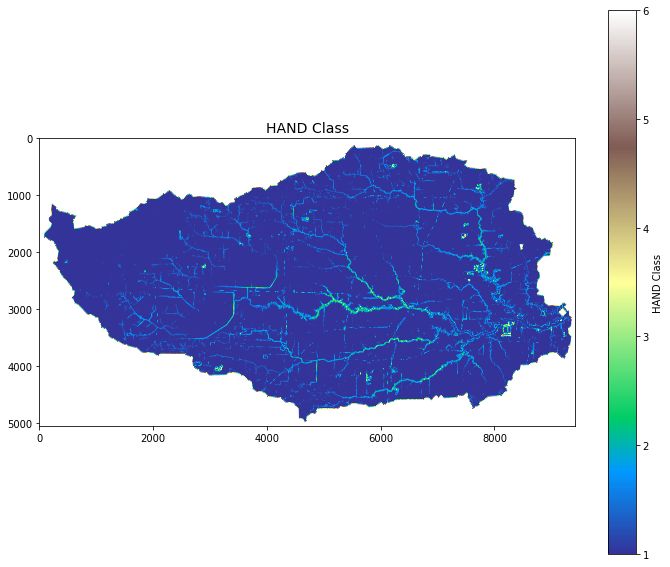

In [95]:
fig, ax = plt.subplots(figsize=(12,10))
plt.imshow(classes, zorder=1, cmap='terrain')
plt.colorbar(label='HAND Class')
plt.title('HAND Class', size=14)

In [ ]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [97]:
grid.to_raster(hand, 'data/HAND.tif')

In [133]:
#import wof
wofs= rasterio.open('data/water_warped.tif').read(1)
hand= rasterio.open('data/HAND_warped.tif').read(1)
backscatter= rasterio.open('data/backscatter_warped.tif').read(1)
landcover= rasterio.open('data/landcover_warped.tif').read(1)

In [156]:
results= classify(backscatter, wofs, hand, landcover)

20


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned
/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:250: RuntimeWarning: divide by zero encountered in double_scalars


30


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


40


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


50


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


60
80


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


90


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


111


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


114


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


116


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


121


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


126


/Users/allen/Documents/Python/FloodDetection/env/lib/python3.6/site-packages/ipykernel_launcher.py:238: RankWarning: Polyfit may be poorly conditioned


In [160]:
np.nanmax(results)

1.0

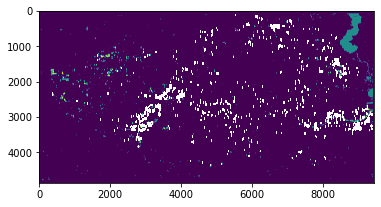

In [158]:
plt.imshow(results)